In [1]:
from pathlib import Path
import xarray as xr
import pandas as pd
import numpy as np
from xhistogram.xarray import histogram as xhist
import cartopy.crs as ccrs
import cartopy.feature as cpf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter 
import matplotlib.colors as colors
import re
import cmocean as cmo
import seaborn as sns

##  First plotting of urchin trajectories

In [53]:
out_path = "/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_weekly_runs/"
year_list = np.arange(2007,2017).tolist()
out_files = sorted(Path(out_path).glob("*.nc"))
output_dt_in_h = 24


def read_output(file):    
    return xr.open_dataset(file)


def load_ds(year):
    
    out_path = "/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_weekly_runs/" +str(year)
    out_files = sorted(Path(out_path).glob("*.nc"))

    ds = xr.concat(map(read_output, out_files), dim="traj")
    print(f'loaded {len(out_files)} files in year {year}')
    return ds, len(out_files)

def calculate_heatmap(output_dataset, lat_bins=None, lon_bins=None):
    heat_map = xhist(
        output_dataset.lat,
        output_dataset.lon,
        bins=[lat_bins, lon_bins],
        dim=["traj"],
    )
    
    heat_map = heat_map.where(heat_map > 0)  
    return heat_map

def yearly_heatmap(year):
    ds,num = load_ds(year)
    heatmap = calculate_heatmap(ds, lat_bins, lon_bins)
    return ds,heatmap,num

def calc_mort_heatmap(data, lat_bins,lon_bins,photo = True ):
    
    data = data.copy()

    if photo:
        #print('mortality; with photos.')
        m = -0.092683473
        data = data.isel(obs = slice(0,181))

    else:
        #print('mortality; without photos.')
        m = -0.164783335
        data = data.isel(obs = slice(0,101))

    t = data.obs
    n0 = data.traj.size
    weight = np.exp(m*t)
    int_heat = calculate_heatmap(data.isel(obs = slice(0,-1)), lat_bins=lat_bins, lon_bins=lon_bins)
    mort_heatmap = (int_heat * weight[:-1]).sum('obs')
        #analytical integ. particles
    particle_sum = int(np.sum(n0 * np.exp(m*t)))
        #diff to integ.mortality heatmap to analytical mortality
    err_diff = mort_heatmap.sum()-particle_sum
    #print(f'Rel. Difference to integr. particles: {np.round(abs(err_diff.values)/n0,4)}')
    return mort_heatmap


In [4]:
#load velocity data mean
data_path = Path("/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/output/")

x_lines = [-25, -20,-15,-10]
y_lines = [16,18,20,22,24,26,28,30]

u_file = list(Path(data_path).glob(f"1_VIKING20X.L46-KFS003_1m_{year_list[0]}*grid_U.nc"))
v_file = list(Path(data_path).glob(f"1_VIKING20X.L46-KFS003_1m_{year_list[0]}*grid_V.nc"))

ds_u = xr.open_dataset(u_file[0]).vozocrtx[:,0:5,:,:]
ds_v = xr.open_dataset(v_file[0]).vomecrty[:,0:5,:,:]

ulat = ds_u.coords["nav_lat"].values[:,0]
ulon = ds_u.coords["nav_lon"].values[0,:]

y_ind = np.where((ulat > y_lines[0]) & (ulat < 30))[0]
x_ind = np.where((ulon > x_lines[0]) & (ulon < x_lines[-1]))[0]
    
u_conc = ds_u[:,:,y_ind,x_ind].mean("depthu").mean('time_counter')
v_conc = ds_v[:,:,y_ind,x_ind].mean("depthv").mean('time_counter')

In [5]:
#load_10year mean velocity data
for year in year_list[1:]:
    u_file = list(Path(data_path).glob(f"1_VIKING20X.L46-KFS003_1m_{year}*grid_U.nc"))
    v_file = list(Path(data_path).glob(f"1_VIKING20X.L46-KFS003_1m_{year}*grid_V.nc"))
    
    ds_u = xr.open_dataset(u_file[0]).vozocrtx[:,0:5,y_ind,x_ind].mean("depthu").mean('time_counter')
    ds_v = xr.open_dataset(v_file[0]).vomecrty[:,0:5,y_ind,x_ind].mean("depthv").mean('time_counter')
    
    u_conc = xr.concat((u_conc, ds_u), dim = 'year')
    v_conc = xr.concat((v_conc, ds_v), dim = 'year')
    
u_mean = u_conc.mean('year')
v_mean = v_conc.mean('year')

In [6]:
#t_grid bathy
t_file = "1_VIKING20X.L46-KFS003_1d_20110101_20111231_grid_T.nc"
t = xr.open_dataset(data_path / t_file)

t_lat = t.coords["nav_lat"].values[1:,0]
t_lon = t.coords["nav_lon"].values[0,:]
t_sel = t.vosaline[:,:,y_ind,x_ind].sel(time_counter = "2011-01-01")

depth_ind = t_sel.where(t_sel == 0).fillna(1).sum(dim = "deptht").astype('int') #depth of cell
depth_tgrid =  t_sel.deptht.isel(deptht = depth_ind)
mesh_t_lon, mesh_t_lat = np.meshgrid(t_lon[x_ind],t_lat[y_ind])

lat_bins = t_sel.coords['nav_lat'].values[:,0]
lon_bins = t_sel.coords['nav_lon'].values[0,:]

In [71]:
#calc or load heatmaps
load_heatmaps = False

heatmap180_list = year_list.copy()
heatmap100_list = year_list.copy()
hm_nomort_list = year_list.copy()

if load_heatmaps:
    hm_path = "/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/"
    
    for i,year in enumerate(year_list):
        
        hm_nomort_list[i] = xr.open_dataarray(Path(hm_path  + f"hm_nomort_1st_gen{year}.nc"))
        heatmap180_list[i] = xr.open_dataarray(Path(hm_path  + f"hm_photo_1st_gen{year}.nc"))
        heatmap100_list[i] = xr.open_dataarray(Path(hm_path  + f"hm_nophoto_1st_gen{year}.nc"))
else:
    num_list = year_list.copy()

    for i, year in enumerate(year_list):
        
        ds,hm_nomort_list[i],num_list[i] = yearly_heatmap(year)
        heatmap180_list[i] = calc_mort_heatmap(ds, lat_bins, lon_bins,photo = True)
        heatmap100_list[i] = calc_mort_heatmap(ds, lat_bins, lon_bins,photo = False)

    print(f'number of weeks loaded: {np.array(num_list).sum()}')
    #calc mean and std of ensemble

loaded 52 files in year 2007
loaded 52 files in year 2008
loaded 52 files in year 2009
loaded 52 files in year 2010
loaded 52 files in year 2011
loaded 52 files in year 2012
loaded 52 files in year 2013
loaded 52 files in year 2014
loaded 52 files in year 2015
loaded 52 files in year 2016
number of weeks loaded: 520


In [72]:
#Ensemble means over 10 years
hm_concat = xr.concat(heatmap_list, dim = 'year')
hm_concat_100 = xr.concat(heatmap100_list, dim = 'year')
ensemble_mean = hm_concat.mean('year')
ensemble_100_mean = hm_concat_100.mean('year')

hm_nomort = xr.concat(hm_nomort_list, dim = 'year')
hm_nomort_mean = hm_nomort.sum('obs').mean('year')

In [73]:
#cut non-shelf bathy
bath = depth_tgrid.squeeze()[1:,:-1]
bath_canary = bath.where((bath['nav_lat'] >=27.65)&(bath['nav_lon'] <=-14.45))
bath_canary2 = bath.where((bath['nav_lat'] >=28)&(bath['nav_lon'] <=-13.45))
bath_canary3 = bath.where((bath['nav_lat'] >=28.9)&(bath['nav_lon'] <=-12.8))
bath_fuerte = bath.where((bath['nav_lat'] >=28.4)&(bath['nav_lon'] <=-13.2))#cut eastern side of fuerteventure, Lanzarote
bath_smount = bath.where((bath['nav_lat'] >=29.5)&(bath['nav_lon'] <=-11.9))#cut  conception seamount
#for release zone
bath_relzone = bath.where((bath_canary == bath)&(bath['nav_lon'] >=-17)&(bath['nav_lon'] <=-16)&(bath>4)&(bath<500))
#african shelf
bath_afr = bath.where((bath_canary != bath)&(bath_canary3 != bath)&(bath_canary2 != bath)&(bath_fuerte != bath)&(bath_smount != bath)&(bath['nav_lon'] >=-17.9))

In [63]:
#get shelf trajs
#load Polygon 
from shapely.geometry import Polygon, Point
exterior = pd.read_csv(Path('/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/target_zone_shelf.csv')).values.tolist()
box_shelf = Polygon(exterior, [])  

def read_shelf_traj(file):
    out_ds = xr.open_dataset(file).compute()
    
    lat_outds = out_ds.isel(obs = 180)['lat'].values
    lon_outds = out_ds.isel(obs = 180)['lon'].values

    points = [Point(lon, lat) for lat, lon in zip(lat_outds, lon_outds)]
    indices = np.array([i for i, point in enumerate(points) if box_shelf.contains(point)])

    shelf_trajs = out_ds.isel(traj = indices)
    
    return shelf_trajs

def read_shelf_traj100(file):
    out_ds = xr.open_dataset(file).compute()
    
    lat_outds = out_ds.isel(obs = 101)['lat'].values
    lon_outds = out_ds.isel(obs = 101)['lon'].values

    points = [Point(lon, lat) for lat, lon in zip(lat_outds, lon_outds)]
    indices = np.array([i for i, point in enumerate(points) if box_shelf.contains(point)])

    shelf_trajs = out_ds.isel(traj = indices)
    
    return shelf_trajs

def load_shelf_traj(year, last_index = True):
    
    out_path = "/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_weekly_runs/" +str(year)
    out_files = sorted(Path(out_path).glob("*.nc"))
    
    if last_index:
        ds = xr.concat(map(read_shelf_traj, out_files), dim="traj")
        print(f'loaded shelf traj from {len(out_files)} files in year {year}, {ds.traj.values[-1]} trajs')
    else:
        ds = xr.concat(map(read_shelf_traj100, out_files), dim="traj")
        print(f'loaded shelf traj (102days) from {len(out_files)} files in year {year}, {ds.traj.values[-1]} trajs')
    return ds

shelf_traj_list100 = year_list.copy()
shelf_traj_list180 = year_list.copy()

for i, year in enumerate(year_list):    
    shelf_traj_list180[i] = load_shelf_traj(year)
    shelf_traj_list100[i] = load_shelf_traj(year, last_index = False)
shelf_traj180 = xr.concat(shelf_traj_list180, dim = 'traj')
shelf_traj100 = xr.concat(shelf_traj_list100, dim = 'traj')

#save
#shelf_traj180.to_netcdf(Path("/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/traj_onshelf180.nc"))
#shelf_traj100.to_netcdf(Path("/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/traj_onshelf100.nc"))

loaded shelf traj from 52 files in year 2007, 577 trajs
loaded shelf traj (102days) from 52 files in year 2007, 36 trajs
loaded shelf traj from 52 files in year 2008, 1837 trajs
loaded shelf traj (102days) from 52 files in year 2008, 896 trajs
loaded shelf traj from 52 files in year 2009, 593 trajs
loaded shelf traj (102days) from 52 files in year 2009, 131 trajs
loaded shelf traj from 52 files in year 2010, 2962 trajs
loaded shelf traj (102days) from 52 files in year 2010, 1171 trajs
loaded shelf traj from 52 files in year 2011, 1969 trajs
loaded shelf traj (102days) from 52 files in year 2011, 234 trajs
loaded shelf traj from 52 files in year 2012, 956 trajs
loaded shelf traj (102days) from 52 files in year 2012, 144 trajs
loaded shelf traj from 52 files in year 2013, 1630 trajs
loaded shelf traj (102days) from 52 files in year 2013, 635 trajs
loaded shelf traj from 52 files in year 2014, 1298 trajs
loaded shelf traj (102days) from 52 files in year 2014, 409 trajs
loaded shelf traj f

In [59]:
#count particles at shelf each day
canary_sum = np.zeros((10,180))
afr_sum = np.zeros((10,180))
for i,hm in enumerate(hm_nomort_list):

    for j in range(180):
        hm_day = hm.isel(obs = j)
        canary_hm = np.where(bath_canary<500, hm_day, np.nan)
        afr_hm = np.where(bath_afr<=500, hm_day, np.nan)
        
        canary_sum[i,j] = np.nan_to_num(canary_hm).sum()
        afr_sum[i,j] = np.nan_to_num(afr_hm).sum()

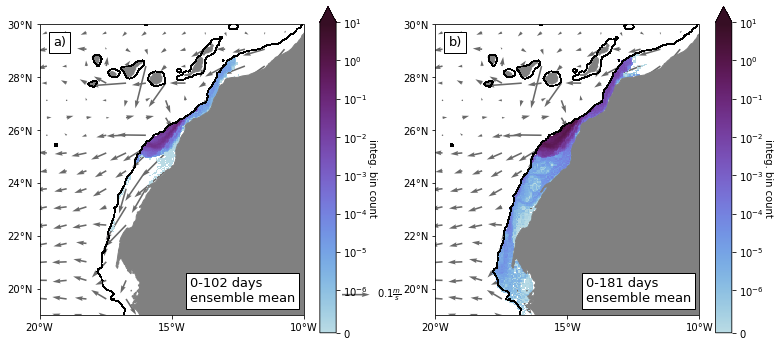

In [79]:
#Fig4
linthresh = 1e-6
vmax = 10
proj = ccrs.PlateCarree()

fig, ax = plt.subplots(1, 2, subplot_kw={"projection": proj}, figsize=(13, 6))
cb_pad = 0.07
cb_fraction = 0.047
textbox = ["0-102 days\nensemble mean","0-181 days\nensemble mean"]
textbox2 = ["a)","b)"]

new_cmap = cmo.tools.crop_by_percent(cmo.cm.dense, 10, which='min', N=None)
formatter = LogFormatter(10, labelOnlyBase=False)
x_mesh,y_mesh = np.meshgrid(lon_bins,lat_bins)

afr_hm = np.where(bath_afr<500, ensemble_mean, np.nan)
afr_hm100 = np.where(bath_afr<500, ensemble_100_mean, np.nan)

pc = ax[0].pcolormesh(x_mesh,y_mesh,np.where(afr_hm100>0, afr_hm100, np.nan), rasterized = True, cmap = new_cmap, 
                      norm=colors.SymLogNorm(linthresh=linthresh, linscale=1,vmin=0, vmax=vmax, base=10))
#                      vmin = 0,vmax = 1)#, zorder = ))
cbar = fig.colorbar(pc, ax =ax[0], pad = cb_pad*0.7, extend = 'max')
cbar.set_label('integ. bin count', rotation=270, labelpad = 9)

pc = ax[1].pcolormesh(x_mesh,y_mesh,np.where(afr_hm>0, afr_hm, np.nan), cmap = new_cmap, rasterized = True , 
                      norm=colors.SymLogNorm(linthresh = linthresh, linscale=1,vmin=0, vmax=vmax, base=10))
                       # vmin = 0,vmax = 1)#, zorder = ))
cbar = fig.colorbar(pc, ax =ax[1], pad = cb_pad*0.7, extend = 'max')
cbar.set_label('integ. bin count', rotation=270, labelpad = 9)


for i, axs in enumerate(ax.flat):    
    axs.annotate(textbox[i],(-14.3,19.5),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )
    axs.annotate(textbox2[i],(-19.5,29.2),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )
    axs.add_feature(cpf.LAND,facecolor='gray',zorder = 2, rasterized = True)
    axs.contour(mesh_t_lon[1:,1:], mesh_t_lat[1:,1:], bath[:,:], colors = "00", linewidths = 0.8,antialiased = False, levels = [500])
    
    #axs.pcolormesh(mesh_t_lon[1:,:], mesh_t_lat[1:,:],bath_relzone[:-1,:], cmap =color2, vmin = 1,vmax = 500,zorder = 4,rasterized = True) # release zone

    axs.set_xticks(x_lines, crs=proj)
    axs.set_yticks(y_lines, crs=proj)
    axs.set_extent((-20,-10,19,30))
    axs.xaxis.set_major_formatter(LongitudeFormatter())
    axs.yaxis.set_major_formatter(LatitudeFormatter()) 

skip = 15
qv_scale = 0.26
qv = ax[0].quiver(ulon[x_ind][::skip], ulat[y_ind][::skip], u_mean[::skip,::skip], v_mean[::skip,::skip], color = 'dimgray', scale =qv_scale, rasterized = True, #2.5
                  scale_units='inches', width = .006,zorder = -1,
                transform = proj)
ax[1].quiver(ulon[x_ind][::skip], ulat[y_ind][::skip], u_mean[::skip,::skip], v_mean[::skip,::skip], color = 'dimgray', scale = qv_scale, rasterized = True, #2.5
             scale_units='inches', width = .006,zorder = -1,
                transform = proj)

ax[0].quiverkey(qv, 1.25, 0.07, .1, r'$0.1 \frac{m}{s}$', labelpos='E', 
                       coordinates='axes',rasterized = True,zorder = -1,);

fig.savefig('pics/fig_1_shelf_bins.svg', format = 'svg', dpi = 700) 
fig.savefig('pics/fig_1_shelf_bins_low_res.svg', format = 'svg')

## Fig S15

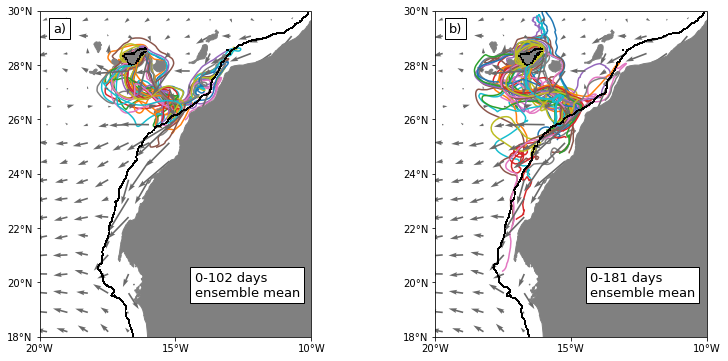

In [64]:
np.random.seed(12)
r_ind100 = random_integers = np.random.randint(0, shelf_traj100['traj'].shape[0], size=50) 
np.random.seed(14)
r_ind180 = random_integers = np.random.randint(0, shelf_traj180['traj'].shape[0], size=50) 

traj_180 = shelf_traj180.isel(traj = r_ind180[:])
traj_100 = shelf_traj100.isel(traj = r_ind100[:],obs = slice(0,101))

color2 = colors.LinearSegmentedColormap.from_list('cmap2', plt.cm.YlOrRd(np.ones(2)*.8))
color0 = colors.LinearSegmentedColormap.from_list('cmap2', plt.cm.Greys(np.ones(2)*1))

fig, ax = plt.subplots(1, 2, subplot_kw={"projection": proj}, figsize=(13, 6))

x_mesh,y_mesh = np.meshgrid(lon_bins,lat_bins)
ax[0].plot(traj_100['lon'].T,
           traj_100['lat'].T, zorder = -1, rasterized = True)

ax[1].plot(traj_180['lon'].T,
           traj_180['lat'].T, zorder = -1, rasterized = True)

for i, axs in enumerate(ax.flat):
    
    axs.annotate(textbox[i],(-14.3,19.5),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )#on africa
    axs.annotate(textbox2[i],(-19.5,29.2),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )#abc

    axs.add_feature(cpf.LAND,facecolor='gray',zorder = 2, rasterized = True)
    axs.contour(mesh_t_lon[:-2,:-1], mesh_t_lat[:-2,:-1], bath_afr[1:,:], colors = "00", linewidths = 0.8,antialiased = False, levels = [500])
    axs.pcolormesh(mesh_t_lon[1:,:], mesh_t_lat[1:,:],bath_relzone[:-1,:], cmap =color0, vmin = 1,vmax = 500,zorder = 4,rasterized = True) # release zone

    axs.set_xticks(x_lines, crs=proj)
    axs.set_yticks(y_lines, crs=proj)
    axs.set_extent((-20,-10,18,30))
    axs.xaxis.set_major_formatter(LongitudeFormatter())
    axs.yaxis.set_major_formatter(LatitudeFormatter()) 

skip = 15

qv = ax[0].quiver(ulon[x_ind][::skip], ulat[y_ind][::skip], u_mean[::skip,::skip], v_mean[::skip,::skip], color = 'dimgray', 
                  scale = qv_scale, rasterized = True, scale_units='inches', width = .006,
                transform = proj)
ax[1].quiver(ulon[x_ind][::skip], ulat[y_ind][::skip], u_mean[::skip,::skip], v_mean[::skip,::skip], color = 'dimgray', 
             scale =qv_scale, rasterized = True, scale_units='inches',width = .006,
                transform = proj);

#plt.savefig('pics/fig_S1_shelf_trajectories.svg', format = 'svg', dpi = 700) 
#plt.savefig('pics/fig_S1_shelf_trajectories_low_res.svg', format = 'svg')
#plt.savefig('pics/shelf_102_181_trajectories.png', dpi = 300, bbox_inches = 'tight') 

## Fig. S16

In [65]:
#particles on shelf 
def count_in_shallow(mean_sum):
    return np.cumsum(np.where(np.ediff1d(mean_sum)>0, np.ediff1d(mean_sum),0))

print(f'number on shelf at day 102 {afr_sum[:,101].sum()}')
print(f'number on shelf at day 181 {afr_sum[:,-1].sum()}')

print(f'10y std  at day 102 {afr_sum[:,101].std()}')
print(f'10y std at day 181 {afr_sum[:,-1].std()}')
fold = np.round(afr_sum[:,-1].mean() / afr_sum[:,101].mean(),2)
print(f'{fold} fold')

number on shelf at day 102 7191.0
number on shelf at day 181 21019.0
10y std  at day 102 811.0164548269042
10y std at day 181 2908.767658304802
2.92 fold


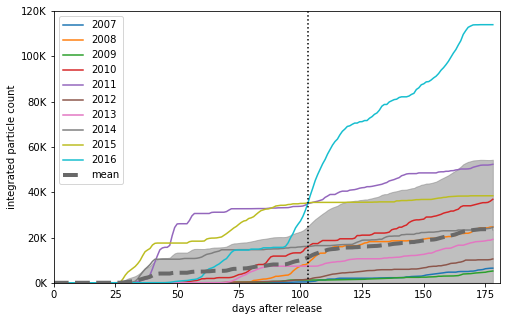

In [66]:
import matplotlib.ticker as ticker
scale_factor = 10 #520k per year scaled to 5.2mill
afr_cumsum = np.zeros_like(afr_sum)

plt.figure(figsize = (8,5))
for i in range(10):
    afr_cumsum[i,1:] = count_in_shallow(afr_sum[i,:]) * scale_factor
    plt.plot(count_in_shallow(afr_sum[i,:])*scale_factor, label = str(year_list[i]), zorder = 2)

plt.plot(count_in_shallow(np.mean(afr_sum, axis = 0))*scale_factor, lw = 4,c = 'dimgrey',ls = '--', label = 'mean')
neg_std = count_in_shallow(np.mean(afr_sum, axis = 0)) *scale_factor - np.std(afr_cumsum, axis = 0)[1:]
pos_std = count_in_shallow(np.mean(afr_sum, axis = 0)) *scale_factor+ np.std(afr_cumsum, axis = 0)[1:] 


plt.fill_between(range(179),np.where(neg_std<0,0,neg_std) ,pos_std, color = 'grey', alpha = .5, zorder = 0)
plt.legend()

plt.vlines(103,0,300e3,ls = ':', color = '00')

plt.xlabel('days after release')
plt.ylabel('integrated particle count')
plt.xlim(0,181)
plt.ylim(0,120e3)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}K'))
#plt.savefig('pics/shelf_timeline_yearly_integ.svg', format = 'svg', dpi = 700) 

In [68]:
#save heatmaps
for i,year in enumerate(year_list):
    
    hm_nomort_list[i].to_netcdf(Path(hm_path + f"hm_nomort_1st_gen{year}.nc"))
    heatmap100_list[i].to_netcdf(Path(hm_path + f"hm_nophoto_1st_gen{year}.nc"))
    heatmap180_list[i].to_netcdf(Path(hm_path + f"hm_photo_1st_gen{year}.nc"))